<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Data Cleaning - Part II		

---

### Cleaning Guide:

- [Data Inspection](#initial) 
- [Reducing Variables](#subset) 
- [Filtering Variables](#filtering_variables)
    - [Auction Venue](#venue)
    - [Artist](#artist)
    - [Art Period](#art_year)
    - [Art Medium](#art_medium)
- [Historical Pricing](#previousprice)
- [Final Dataset](#dataset)

In [2]:
import pandas as pd
import numpy as np
import re, time
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import DBSCAN,KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, linear_model, metrics
from nltk.corpus import stopwords
import scikitplot as skplt
from scikitplot.cluster import plot_elbow_curve
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import requests
import bs4
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook

import warnings
warnings.simplefilter('ignore')
%config InlineBackend.figure_format = 'retina'
# pd.set_option('display.max_rows', 1000)

### Data inspection

---
<a id="initial"></a>

In [3]:
df = pd.read_csv('./auction_data.csv')

In [4]:
df[df.Title == 'Hopeless']

,Unnamed: 0,Art_medium,Artist,Artist_url,Dimensions,Estimate_Price,Image_url,Realized_Price,Sale_date,Signed,...,Title,Title_url,Venue,Year,Print_number,Total_prints,Dimension_units,Dimemsion_values_d,dimension_inch,Area_dimension
46490,46490,Color offset lithograph,Roy Lichtenstein,https://www.mutualart.com/Artist/Roy-Lichtenst...,40 x 40 in.,NaN,https://media.mutualart.com/Images/2014_09/11/...,35000,Sep 29 2014,1,...,Hopeless,https://www.mutualart.com/Artwork/Hopeless/B2F...,"Leslie Hindman Auctioneers, Chicago",1964.0,1,1.0,['in'],"[40.0, 40.0]","[40.0, 40.0]",1600.0


In [77]:
df.head(1)

,Unnamed: 0,Art_medium,Artist,Artist_url,Dimensions,Estimate_Price,Image_url,Realized_Price,Sale_date,Signed,...,Title,Title_url,Venue,Year,Print_number,Total_prints,Dimension_units,Dimemsion_values_d,dimension_inch,Area_dimension
0,0,"Color offset lithogragh, screen and pochoir wi...",Robert Rauschenberg,https://www.mutualart.com/Artist/Robert-Rausch...,27 x 21 1/2 inches,960.0,https://media.mutualart.com/Images/2012_10/12/...,1000,Oct 16 2012,1,...,HORSEFEATHERS THIRTEEN-XIII,https://www.mutualart.com/Artwork/HORSEFEATHER...,Doyle New York,1972.0,9/78,78.0,['in'],"[27.0, 21.5]","[27.0, 21.5]",580.5


In [78]:
df.drop(columns = 'Unnamed: 0', inplace =True)

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165438 entries, 0 to 165437
Data columns (total 20 columns):
Art_medium            150621 non-null object
Artist                165069 non-null object
Artist_url            165069 non-null object
Dimensions            154605 non-null object
Estimate_Price        73291 non-null float64
Image_url             165273 non-null object
Realized_Price        165438 non-null int64
Sale_date             165273 non-null object
Signed                165438 non-null int64
Similar_items         165231 non-null object
Title                 165438 non-null object
Title_url             165438 non-null object
Venue                 165273 non-null object
Year                  135558 non-null float64
Print_number          165425 non-null object
Total_prints          162945 non-null float64
Dimension_units       154605 non-null object
Dimemsion_values_d    154605 non-null object
dimension_inch        142996 non-null object
Area_dimension        141775 non-n

In [80]:
df.isnull().sum()

Art_medium            14817
Artist                  369
Artist_url              369
Dimensions            10833
Estimate_Price        92147
Image_url               165
Realized_Price            0
Sale_date               165
Signed                    0
Similar_items           207
Title                     0
Title_url                 0
Venue                   165
Year                  29880
Print_number             13
Total_prints           2493
Dimension_units       10833
Dimemsion_values_d    10833
dimension_inch        22442
Area_dimension        23663
dtype: int64

In [81]:
df.shape

(165438, 20)

### Reducing the number of variables:

---
<a id="subset"></a>

<u> The streamline the dataframe and reduce it to the most useful features, the following needs to be done:</u>
- Remove all Columns with Website URLs, these were scraped for potential future scraping use for more information such as downloading the image or description of artwork.
- Estimated price has over 80,000 NaN values out of 144202 data points, therefore will drop for now but could potentially analyse as a small subset later.
- Remove the columns with dimension variables used to calculate the area variable.

In [82]:
subset = df[['Title','Artist','Year','Venue','Art_medium','Signed','Total_prints','Area_dimension','Realized_Price','Sale_date']]

In [83]:
subset.head(30)

,Title,Artist,Year,Venue,Art_medium,Signed,Total_prints,Area_dimension,Realized_Price,Sale_date
0,HORSEFEATHERS THIRTEEN-XIII,Robert Rauschenberg,1972.0,Doyle New York,"Color offset lithogragh, screen and pochoir wi...",1,78.0,580.500000,1000,Oct 16 2012
1,Starry Night June,Pat Steir,1996.0,Dallas Auction Gallery,color soap ground aquatint,1,40.0,700.687500,1000,Oct 24 2012
2,Orchids,Louis Icart,1937.0,Freeman's,"Color etching with aquatint, drypoint & hand-c...",1,1.0,515.625000,1000,May 08 2002
3,Mrs Anne Murray (née Campbell-Colquhoun) (b. c...,John Bogle,1794.0,Bonhams Oxford,engraved,1,1.0,4.000000,1000,Nov 28 2012
4,Horsefeathers Thirteen XV,Robert Rauschenberg,1972.0,Swann Auction Galleries,"Color lithograph, screenprint, pochoir, collag...",1,1.0,279.500000,1000,Nov 15 2012
5,White House Signing of the Eqyptian Israeli Pe...,LeRoy Neiman,1980.0,Ro Gallery,Serigraph,1,300.0,997.500000,1000,Oct 04 2012
6,"Four works: The Landscape Series, ""Promising,""...",Iain Baxter,1998.0,Stair Galleries,mixed media monoprints on paper,1,1.0,622.500000,1000,Jul 27 2012
7,Olympic Swimmer,Alex Katz,NaN,Freeman's,Color silkscreen,1,200.0,998.437500,1000,May 21 2004
8,Solar Flare up,Rockwell Kent,1937.0,Freeman's,Lithograph on G.C.M. paper,1,1.0,188.000000,1000,Oct 28 2005
9,Yours Truly,ASVP,2012.0,Doyle New York,Color screenprint,1,5.0,660.000000,1000,Apr 08 2013


In [85]:
subset.isnull().sum()

Title                 0
Artist              369
Year              29711
Venue               165
Art_medium        14817
Signed                0
Total_prints          0
Area_dimension    23432
Realized_Price        0
Sale_date           165
dtype: int64

- Dropping all rows with NaN values:

In [86]:
subset.dropna(inplace = True)

In [87]:
subset.shape

(122003, 10)

In [88]:
subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122003 entries, 0 to 165437
Data columns (total 10 columns):
Title             122003 non-null object
Artist            122003 non-null object
Year              122003 non-null float64
Venue             122003 non-null object
Art_medium        122003 non-null object
Signed            122003 non-null int64
Total_prints      122003 non-null float64
Area_dimension    122003 non-null float64
Realized_Price    122003 non-null int64
Sale_date         122003 non-null object
dtypes: float64(3), int64(2), object(5)
memory usage: 10.2+ MB


In [89]:
for i in subset.columns:
    print(i,': ',len(subset[str(i)].value_counts()))
    
print()
print(subset.shape)

Title :  78703
Artist :  4541
Year :  527
Venue :  606
Art_medium :  31165
Signed :  2
Total_prints :  511
Area_dimension :  37806
Realized_Price :  17289
Sale_date :  3412

(122003, 10)


### Filtering Variables

---
<a id="filtering_variables"></a>

<u> After inspecting the value counts for all the variables:</u>
- There are 3900 artists, 28086 different art medium used, 579 Venues and over 68935 titles (aka different pieces of art). These variables need to be filtered and grouped to make it more practical for modelling.
- The Year and Sale date variables also have a wide range and therefore it would be beneficial to group/ organise

#### Seperating Sale Date to Year, Month and Day:

---
<a id="saledate"></a>

In [91]:
subset.Sale_date = subset.Sale_date.apply(lambda x: pd.to_datetime(x))

In [92]:
subset['Sale_Year'] = subset.Sale_date.apply(lambda x: x.year)
subset['Sale_Month'] = subset.Sale_date.apply(lambda x: x.month)
subset['Sale_Day'] = subset.Sale_date.apply(lambda x: x.day)

#### Auction Venue, filtering down to cities only:

---
<a id="venue"></a>

In [45]:
venuelist = subset.Venue.unique().tolist()

In [50]:
len(venuelist)

579

In [103]:
venuelist1 = venuelist[:100]
venuelist2 = venuelist[100:200]
venuelist3 = venuelist[200:300]
venuelist4 = venuelist[300:400]
venuelist5 = venuelist[400:500]
venuelist6 = venuelist[500:579]

In [ ]:
venuelist_ = [venuelist1, venuelist2, venuelist3, venuelist4, venuelist5, venuelist6]

#### Using Selenium to search and web-scrape the location/address of the Auction House:</u></li>
- Automating Selenium to search and iterate through the list of auction house, extracting the venue address
- Creating a dictionary of venues : address

In [87]:
#Google code:
login_url = 'https://www.google.com/'
driver = webdriver.Chrome('./chromedriver')
driver.implicitly_wait(1)

venuedict6 = {}
for i in venuelist6:
    driver.get(login_url)
    time.sleep(0.5)
    searchElem = driver.find_elements_by_xpath('//*[@id="tsf"]/div[2]/div/div[1]/div/div[1]/input')[0]
    searchElem.send_keys(i+' auction house address')
    searchElem.send_keys(u'\ue007');
    time.sleep(0.5)
    try:
        venuedict6[i] = driver.find_elements_by_xpath('//*[@id="rhs_block"]/div/div[1]/div/div[1]/div[2]/div[2]/div/div[2]/div/div/span[2]')[0].text
    except:
        try:
            venuedict6[i]= driver.find_elements_by_xpath('//*[@id="rhs_block"]/div/div[1]/div/div[1]/div[2]/div[2]/div/div[3]/div/div/span[2]')[0].text
        except:
            venuedict6[i]=np.nan

In [ ]:
venuedictionary = [venuedict2, venuedict3, venuedict4, venuedict5, venuedict6]

In [95]:
for i in venuedictionary:
    venuedict1.update(i)

In [124]:
venuedict1

{'Doyle New York': '175 E 87th St, New York, NY 10128, USA',
 'Dallas Auction Gallery': '2235 Monitor St, Dallas, TX 75207, USA',
 "Freeman's": '1808 Chestnut St, Philadelphia, PA 19103, USA',
 'Bonhams Oxford': 'Banbury Rd, Kidlington OX5 1JH',
 'Swann Auction Galleries': '104 E 25th St #6, New York, NY 10010, USA',
 'Ro Gallery': '47-15 36th St, Long Island City, NY 11101, USA',
 'Stair Galleries': '549 Warren St, Hudson, NY 12534, USA',
 'The Potomack Company': '1120 N Fairfax St, Alexandria, VA 22314, USA',
 'Rachel Davis Fine Arts': '1301 W 79th St, Cleveland, OH 44102, USA',
 "Weschler's": '40 W Gude Dr Suite #100, Rockville, MD 20850, USA',
 'Dreweatts & Bloomsbury Auctions, Bloomsbury House': "16-17 Pall Mall, St. James's, London SW1Y 5LU",
 "Sotheby's New York": '1334 York Ave, New York, NY 10021, USA',
 'Wright': '1440 W Hubbard St, Chicago, IL 60642, USA',
 'Morton Kuehnert': nan,
 "Christie's New York": nan,
 'Copley Fine Art Auctions': '65 Sharp St, Hingham, MA 02043, USA'

<u> Loading in the world city csv from datahub:</u>
- (Source: https://datahub.io/core/world-cities)

In [7]:
worldcities = pd.read_csv('./dataset/world-cities.csv')
citynames = worldcities.name

In [91]:
venue_address = pd.DataFrame([venuedict1]).T.reset_index()
venue_address.rename(columns={'index':'Name',0:'Address'}, inplace=True)

- By combing the dictionary created from webscraping and the city list from the loaded csv
- A further streamlined dictionary can be created, giving venue : city

In [102]:
newdictven = {}
for b,i in enumerate(venue_address.Name):
    j = re.findall(r"\w+", i)
    newdictven[i] = 1
    for k in j:
        for city in citynames:
            if city == k:
                newdictven[i] = city
        if newdictven[i] == 1:
            try:
                a = re.findall(r"\w+", venue_address.Address[b])
                for c in a:
                    for city in citynames:
                        if city == c:
                            newdictven[i] = city
                    if newdictven[i]==1:
                        newdictven[i] = venue_address.Address[b]
            except:
                newdictven[i] = np.nan
                    

In [100]:
#Function for mapping venue to the city its from
def venue_city(x):
    try:
        return newdictven[x]
    except:
        return np.nan

Creating a new column with the auction venue's city:

In [101]:
subset['Venue_city'] = subset.Venue.apply(venue_city)

In [146]:
len(subset.Venue_city.value_counts())

281

In [104]:
subset.to_csv('./subset.csv')

### Filtering Top Artists by count:

---
<a id="artist"></a>

- There's over 4541 artists in the dataset
- However only the top 300 artists have had at least 40 sales count
- The rest have less, majority of which only sold once
- Therefore I will filter the dataset to only include the top 300 artists

In [106]:
len(subset.Artist.value_counts())

4541

In [152]:
subset.Artist.value_counts()[:300]

Pablo Picasso                9249
Andy Warhol                  7005
Joan Miró                    5428
Marc Chagall                 4647
Rembrandt van Rijn           4200
Roy Lichtenstein             2829
David Hockney                2100
Albrecht Dürer               2019
Henri Matisse                1875
Jasper Johns                 1354
Frank Stella                 1268
Salvador Dalí                1147
Yayoi Kusama                 1131
Henri de Toulouse-Lautrec    1097
Banksy                       1070
Takashi Murakami             1062
Damien Hirst                 1040
Robert Motherwell             983
Zao Wou-Ki                    976
Robert Rauschenberg           959
Tom Wesselmann                944
Keith Haring                  941
Ellsworth Kelly               924
James McNeill Whistler        896
Ed Ruscha                     841
Sam Francis                   814
Thomas Hart Benton            792
Rufino Tamayo                 757
Jim Dine                      755
Georges Braque

In [155]:
subset.Artist.value_counts().tail(10)

Henry John Elwes             1
Frederick D. Jones           1
Gianni Penati                1
Katharina Fritsch            1
Georg Muche                  1
Rowan Gillespie              1
Harry Kernoff                1
Leonard Russell Squirrell    1
Maggie Taylor                1
Josif Charlemagne            1
Name: Artist, dtype: int64

In [156]:
Top_Artists = subset.Artist.value_counts().index.tolist()[:300]

In [157]:
subset_a = subset[subset.Artist.isin(Top_Artists)]

In [158]:
subset_a.to_csv('./subset_a.csv')

### Artwork Year -  filtering to historical Art Periods:

---
<a id="art_year"></a>

- The artwork sold range can range from 1500s to recent years
- From a consumers point of view rather the specific year the art was made, the more important feature is the period the art is from. E.g. the difference between an artwork from the 1500s and 1600s won't be as different in comparison to something from 1800s to 1900s.
- Hence I will be categorizing/ grouping the year of the artwork to art historical periods.


<b>Problem:</b>
- Taking a look at the max and min years 
- The maximum year is beyond the present date
- Further looking into the works in 1000 and 2100, both of these include picasso
- Therefore, the year column is now unreliable and cannot be used


In [111]:
print(max(subset.Year))
print(min(subset.Year))

2100.0
1000.0


In [810]:
subset[subset.Year>2019].head(2)

,Title,Artist,Year,Venue,Art_medium,Signed,Total_prints,Area_dimension,Realized_Price,Sale_date,Sale_Year,Sale_Month,Sale_Day,Venue_city
45549,ALBUM 21,Joan Miró,2100.0,Doyle New York,Color lithograph,1,75.0,502.890625,3125,2018-10-22,2018,10,22,New York
66496,Bouquet de fleurs,Pablo Picasso,2100.0,Geneva Auction,Lithograph,1,100.0,405.165960,4443,2018-09-18,2018,9,18,Geneva


In [811]:
subset[subset.Year<1200].head(2)

,Title,Artist,Year,Venue,Art_medium,Signed,Total_prints,Area_dimension,Realized_Price,Sale_date,Sale_Year,Sale_Month,Sale_Day,Venue_city
34605,La Femme au Bandeau (B.; Ba. 1306IIIBa),Pablo Picasso,1081.0,Christie's London,linocut in light brown,1,50.0,146.69802,32489,2004-06-30,2004,6,30,London
35131,CB,Cecily Brown,1122.0,Christie's New York,monotype on lanaquarelle,1,1.0,1728.00000,35000,2013-09-26,2013,9,26,New York


<b>Solution:</b>
- Using BeautifulSoup and webscraping through wikipedia for the top 300 artists in our dataframe
- A new column is created with the artists date of birth and date of death (for those who have passed away)

In [478]:
artist_search = [i.replace(' ','_') for i in Top_Artists]

In [494]:
artist_year = {}
for artist in tqdm_notebook(set(artist_search)):
    try:
        alist = []
        URL = 'https://en.wikipedia.org/wiki/{}'.format(artist)
        r = requests.get(URL)
        soupp = BeautifulSoup(r.text, 'html.parser')
        s = soupp.find('table', attrs={'class':'infobox biography vcard'})
        for dates in s.find_all('span', attrs={'style':'display:none'}):
            alist.append(dates.text.strip())
        try:
            s.find_all('span', attrs={'style':'display:none'})
        artist_year[artist]=alist[:2]
    except:
        artist_year[artist]=np.nan

In [515]:
artist_year_df = pd.DataFrame([artist_year]).T.reset_index()

In [531]:
artist_year_df.rename(columns={'index':'Name',0:'Date'}, inplace = True)

In [552]:
def extract_yearonly(x):
    try:
        dates = []
        for i in x:
            j = re.findall(r"\d{4}", i)
            dates.append(j[0])
        return dates
    except:
        return x

In [555]:
artist_year_df.Date = artist_year_df.Date.apply(extract_yearonly)

In [565]:
artist_year_df.head()

,Name,Date
0,A.R._Penck,"[1939, 2017]"
1,Ad_Reinhardt,"[1913, 1967]"
2,Adolph_Gottlieb,"[1903, 1974]"
3,Adriaen_van_Ostade,NaN
4,Afro,NaN


In [558]:
artist_year_df.to_csv('artist_year_df.csv')

In [568]:
artist_df = pd.read_csv('artist_year_df.csv').drop(columns = 'Unnamed: 0')

In [612]:
artist_df[(artist_df['Date'].isnull())]

,Name,Date
377,Portfolio,NaN
463,Various_Artists,NaN


In [709]:
artist_df.to_csv('artist_year_df.csv')

In [112]:
artist_df = pd.read_csv('artist_year_df.csv')

In [113]:
artist_df.drop(columns ='Unnamed: 0', inplace = True)

In [114]:
type(artist_df.Date[0])

str

In [115]:
def to_int(x):
    if isinstance(x,str):
        try:
            i = re.findall(r"\d+", x)
            intlist =[]
            for j in i:
                intlist.append(int(j))
            return intlist
        except:
            pass
    else:
        return x

In [116]:
artist_df.Date = artist_df.Date.apply(to_int)

In [117]:
artist_df.dropna(inplace = True)

<b>Assumption:</b>

- Since I don't have the actual date of each artpiece
- I will now make a new column which is the art period category in which the artist is approximately in.
- Assumption made: Each artists style is defined in the earlier days, approximating it to 30% into their lifespan 
- E.g:
    - Pablo Picasso born 1881, died 1973, 30% into his lifestyle is 1909 this is within the Cubism periods
    - Banksy born 1974, still alive therefore 30% from birth till present day is 1988, placing him within the Postmodernism period

In [766]:
def calc_est_year(x):
    if len(x)==2:
        return round((x[1]-x[0])*0.3+x[0])
    elif len(x)==1:
        return round((2019-x[0])*0.3+x[0])
    else:
        return np.nan

In [768]:
artist_df['Est_Year'] = artist_df.Date.apply(calc_est_year)

In [ ]:
artist_df['Est_Year'] = artist_df.Date.apply(calc_est_year)

In [786]:
print(max(artist_df.Est_Year))
print(min(artist_df.Est_Year))

2004.0
1455.0


#### ART HISTORY TIMELINE:

- Byzantine and Islamic (a.d. 476–a.d.1453)
- Middle Ages (500–1400)
- Renaissance (1400–1550)
- Mannerism (1527–1580), Baroque (1600–1750)
- Neoclassical (1750–1850), Romanticism (1780–1850)
- Realism (1848–1900), Impressionism (1865–1885)
- Post-Impressionism (1885–1910)
- Cubism, Futurism, Supremativism, Constructivism, De Stijl (1905–1920)
- Dada and Surrealism (1917–1930s)
- Abstract Expressionism (1940s–1950s) 
- Pop Art (1960s)
- Postmodernism and Deconstructivism (1970– )

In [ ]:
Pre-1400: Middle Ages
1440-1550: Renaissance
1550-1750: Baroque & Mannerism
1750-1850: Neoclassical & Romanticism
1850-1900: Impressionism & Realism
1900-1920: CFSCD
1920-1940: Dada & Surrealism
1940-1960: Abstract_Expressionism
1960-1970: Pop Art
Post-1970: Post-Modernism

In [813]:
def art_period(x):
    if x < 1400:
        return 'Middle_Ages'
    elif x < 1550:
        return 'Renaissance'
    elif x < 1750:
        return 'Baroque_Mannerism'
    elif x < 1850:
        return 'Neoclassical_Romanticism'
    elif x < 1900:
        return 'Impressionism_Realism'
    elif x < 1920:
        return 'CFSCD'
    elif x < 1940:
        return 'Dada_Surrealism'
    elif x < 1960:
        return 'Abstract_Expressionism'
    elif x < 1970:
        return 'Pop Art'
    else:
        return 'Postmodernism'

In [814]:
artist_df['Art_period'] = artist_df.Est_Year.apply(art_period)

In [816]:
artist_df.to_csv('artist_year_df.csv')

In [817]:
artist_df.rename(columns = {'Name':'Artist'},inplace = True)

In [818]:
artist_df.Artist = artist_df.Artist.apply(lambda x: x.replace('_',' '))

In [163]:
subset_b = subset_a.merge(artist_df, how = 'inner', on = 'Artist')

In [165]:
subset_b.Art_period.value_counts()

Abstract_Expressionism      29624
CFSCD                       23405
Dada_Surrealism             16703
Impressionism_Realism       10509
Pop Art                      8974
Postmodernism                6774
Baroque_Mannerism            4863
Renaissance                  2225
Neoclassical_Romanticism     1117
Name: Art_period, dtype: int64

<b>Adding additional feature: Alive</b>
- Called the "Death Effect" within the industry, this feature I believe will be interesting to explore
- If there is no date of death found then the artist is assumed to be alive still
- The alive column is decided on whether the artist was alive at the point of the artworks auction sale.

In [166]:
def alive(row):
    if len(row['Date']) == 1:
        return 1
    elif row['Date'][1] < row['Sale_Year']:
        return 0
    else:
        return 1

In [167]:
subset.Alive = subset_b.apply(alive, axis = 1)

In [168]:
subset_b.to_csv('subset_b.csv')

In [169]:
subset_b.head()

,Title,Artist,Year,Venue,Art_medium,Signed,Total_prints,Area_dimension,Realized_Price,Sale_date,Sale_Year,Sale_Month,Sale_Day,Venue_city,Date,Alive,Est_Year,Art_period
0,HORSEFEATHERS THIRTEEN-XIII,Robert Rauschenberg,1972.0,Doyle New York,"Color offset lithogragh, screen and pochoir wi...",1,78.0,580.50000,1000,2012-10-16,2012,10,16,New York,"[1925, 2008]",0,1950.0,Abstract_Expressionism
1,Horsefeathers Thirteen XV,Robert Rauschenberg,1972.0,Swann Auction Galleries,"Color lithograph, screenprint, pochoir, collag...",1,1.0,279.50000,1000,2012-11-15,2012,11,15,New York,"[1925, 2008]",0,1950.0,Abstract_Expressionism
2,Gulf,Robert Rauschenberg,1969.0,Gray's Auctioneers,Lithograph in color,1,56.0,1471.34375,1000,2015-07-31,2015,7,31,Cleveland,"[1925, 2008]",0,1950.0,Abstract_Expressionism
3,Jewish Museum,Robert Rauschenberg,1963.0,"Leslie Hindman Auctioneers, Chicago",offset lithograph,1,1.0,688.00000,1000,2019-01-11,2019,1,11,Chicago,"[1925, 2008]",0,1950.0,Abstract_Expressionism
4,Horsefeathers Thirteen - IV,Robert Rauschenberg,1972.0,Clars Auction Gallery,"color offset lithograph, screenprint, pochoir ...",1,89.0,266.25000,1000,2016-03-20,2016,3,20,Oakland,"[1925, 2008]",0,1950.0,Abstract_Expressionism


### Clustering the art medium used into groups:

---
<a id="art_medium"></a>

- With over 24000 different medium descriptions, unless this column is grouped into smaller group, it will be very inefficient to include when modelling. 
- Therefore I will be clustering the different strings into smaller categories 
- First using NLP tools to transform the strings and then process through clustering algorithms

In [66]:
len(subset_b.Art_medium.unique())

24711

In [67]:
medium_df = pd.DataFrame(subset_b.Art_medium.unique().tolist()).rename(columns = {0:'String'})

In [188]:
medium_df.head(2)

,String
0,"Color offset lithogragh, screen and pochoir wi..."
1,"Color lithograph, screenprint, pochoir, collag..."


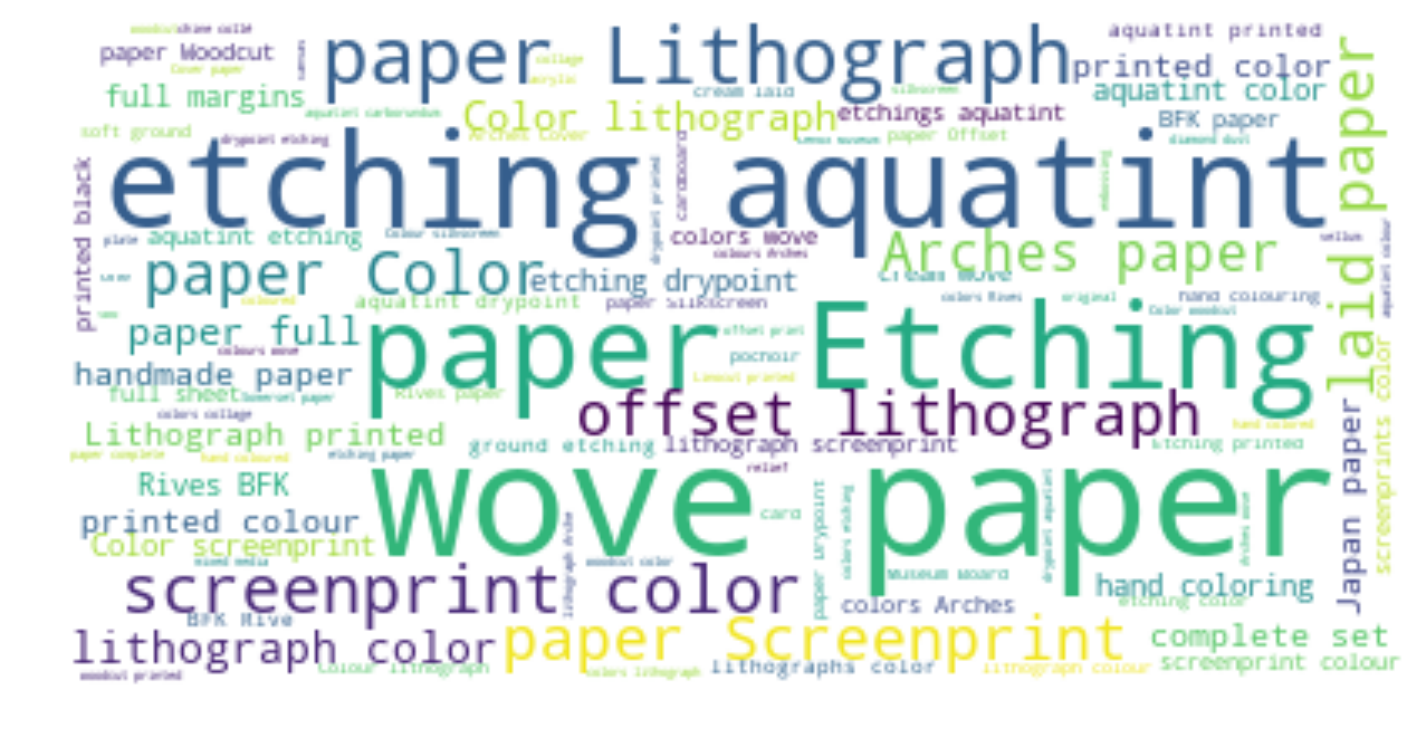

In [75]:
text = [i for i in df.Art_medium.unique().tolist() if isinstance(i,str)]
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(text))
plt.figure(figsize=(12,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Tokenizing the strings using Count Vectorizer/Tfidf-Vectorizer 
---
- Count Vectorizer converts a collection of text document/string to a matrix of token counts
- Tfidf-Vectorizer is equivalent to Count Vectorizer followed by Tfidf-Transformer
- CountVectorizer vs. TfidfVectorizer:
    - CountVectorizer just counts the frequencies 
    - TfidfVectorizer normalizes the count frequency by taking into account of the frequency of the word within the corpus. 
    - The TfidfVectorizer value increases proportionally to count but more frequent words are adjusted so it doesn't overshadow the other terms since less frequent words have more weight.
    
<b><i> Moving forward I will be using TfidfVectorizer to tokenize the strings for clustering. Since for this case it will be useful to normalize and weight the counts as the majority of the string will contain similar words such as "color", "paper", "print" which may over shadow other words which will better distinguish the groups</i></b>


In [9]:
#1. CountVectorizer

cvec = CountVectorizer(stop_words='english', token_pattern='\w+', strip_accents='ascii')
cvec.fit(medium_df.String)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents='ascii', token_pattern='\\w+', tokenizer=None,
        vocabulary=None)

In [10]:
string_matrix = cvec.transform(medium_df.String)

In [11]:
string_df = pd.DataFrame(string_matrix.toarray(),
                  columns=cvec.get_feature_names())

string_df.transpose().sort_values(0, ascending=False).transpose().head()

,pochoir,collage,screen,color,offset,lithogragh,embossing,philea,phoebis,photo,...,fasteners,feathers,fedrigoni,felt,fer,feu,ffset,fiber,fiberboard,zwei
0,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
#2. TfidVectorizer:

tvec = TfidfVectorizer(stop_words='english', token_pattern='\w+',strip_accents='ascii')
tvec.fit(medium_df.String)

string_matrix_ = tvec.transform(medium_df.String)

string_df_ = pd.DataFrame(string_matrix_.toarray(),
                  columns=tvec.get_feature_names())

string_df_.transpose().sort_values(0, ascending=False).transpose().head(2)

,lithogragh,screen,pochoir,embossing,collage,offset,color,pharmacist,philea,phoebis,...,fasteners,feathers,fedrigoni,felt,fer,feu,ffset,fiber,fiberboard,zwei
0,0.643217,0.395318,0.382299,0.306952,0.271684,0.262728,0.216301,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.460925,0.370083,0.327560,0.000000,0.260787,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Principal Component Analysis:
----
- After tokenizing the strings with "stopwords" implemented, there are still 3771 components
- For better and more efficient processing, I will be conducting principal component analysis, a dimension-reduction tool, to reduce the the number of components required to represent information in the medium strings.

Standardizing the tokenized dataframe from the TfidfVectorized strings: 

In [190]:
scaler = StandardScaler()

In [191]:
string_std = pd.DataFrame(scaler.fit_transform(string_df_))

In [192]:
string_cov = string_std.cov()

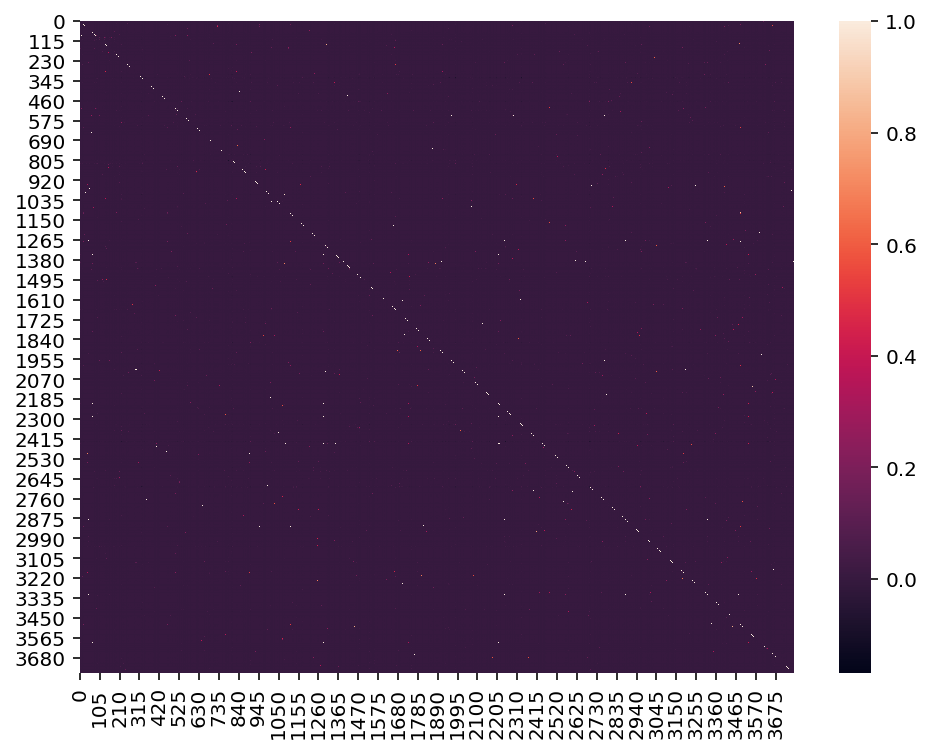

In [195]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()
sns.heatmap(string_cov, ax = ax)
plt.show()

<b>The plots below shows the number of components required to to explain 80%, 90% and 75% of the variences in the medium strings:</b>
- Whereby the explained variances is the proportion to which a mathematical model can account for the variation of the data set (the medium strings)

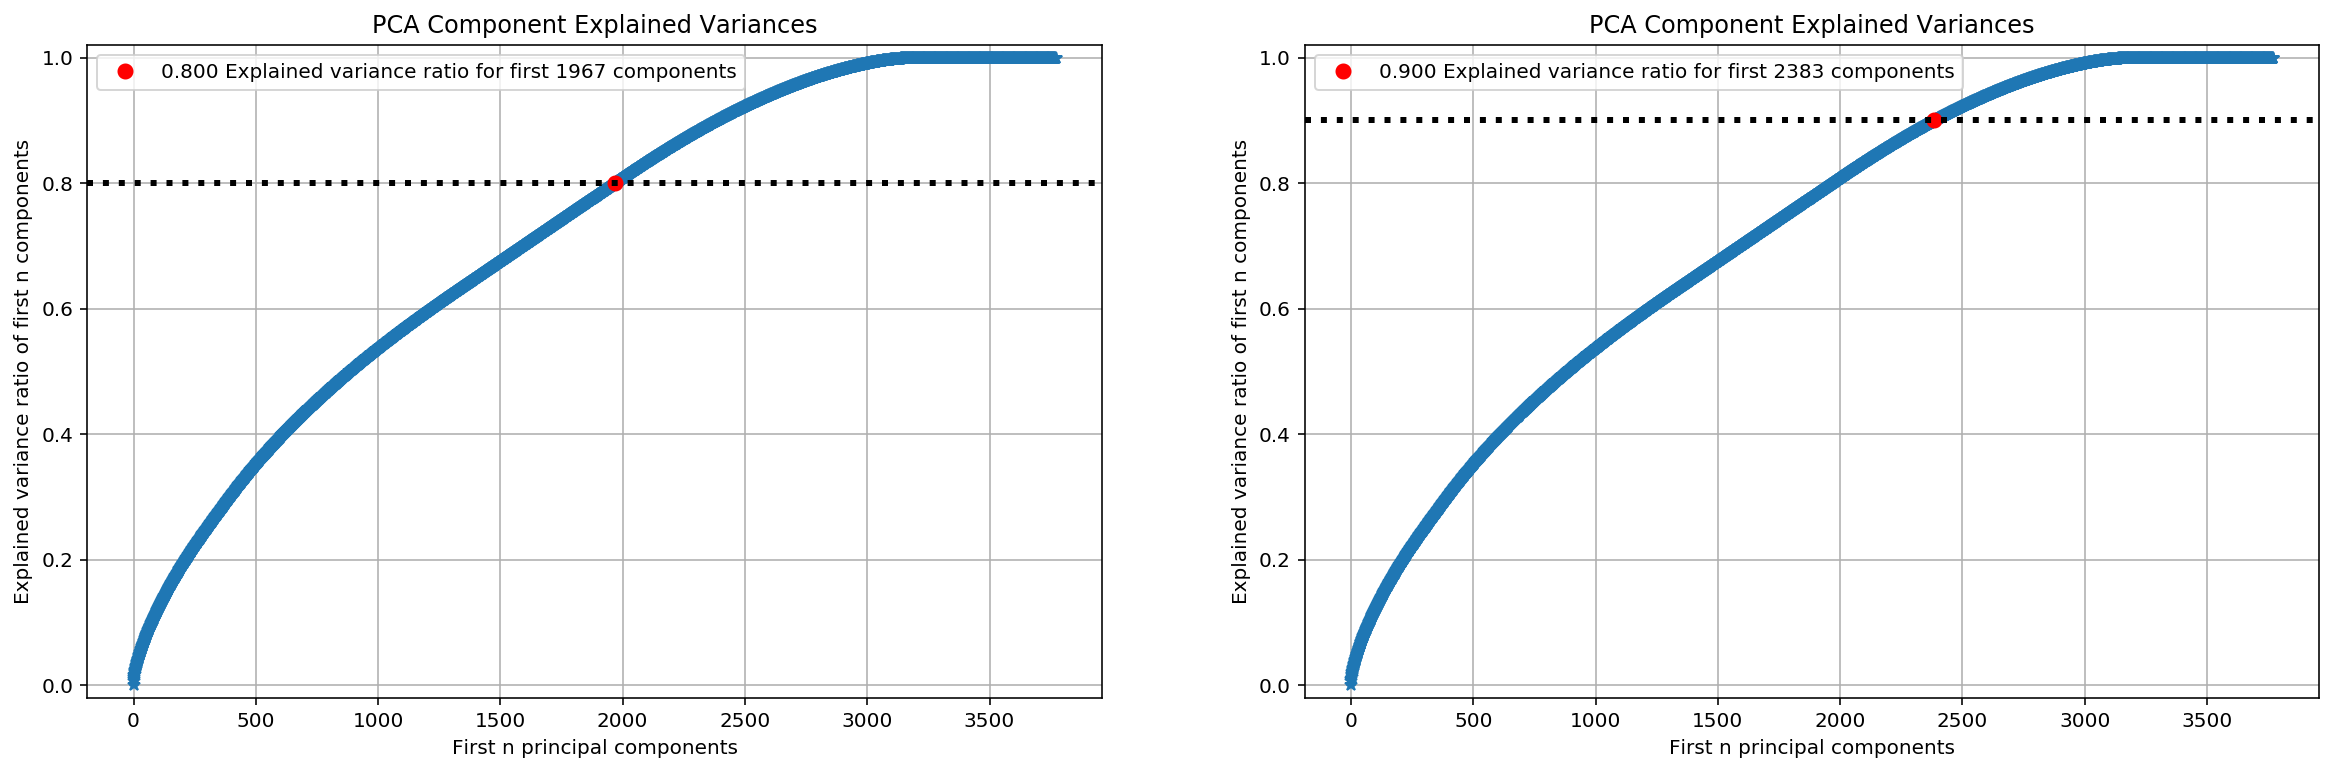

In [70]:
fig, ax = plt.subplots(1,2, figsize=(20, 6))
pca = PCA(random_state=1)
pca.fit(string_std)
skplt.decomposition.plot_pca_component_variance(pca, target_explained_variance=0.8, ax = ax[0])
skplt.decomposition.plot_pca_component_variance(pca, target_explained_variance=0.9, ax = ax[1])

plt.show()

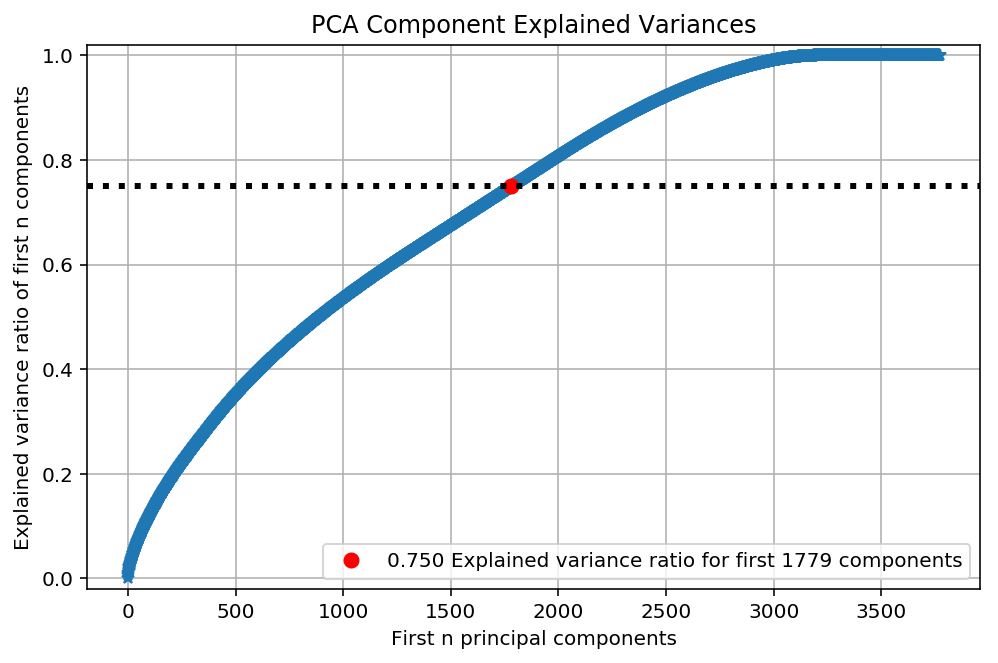

In [78]:
fig = plt.figure(figsize=(8, 5))
ax = fig.gca()
skplt.decomposition.plot_pca_component_variance(pca, ax = ax);

<b>Accepting the PCA analysis which gives 0.75 explained variance ratio: n_components = 1779</b>
- reducing number of components by 53% (from 3771 to 1779)
- fitting and transforming the standardized tokenized strings 

In [19]:
pca_model = PCA(n_components=1779)
pca_model.fit(string_std)
pca_string = pca_model.transform(string_std)

#### Clustering with DBScan and K-mean algorithms:
---
KMeans and DBScan are two of the most popular clustering (unsupervised) algorithms:
- DBScan:
    - DBScan use the concept of reachability i.e. how many neighbors has a point within a radius.
    - DBScan allows for unsupervised clustering without having to set a predetermined cluster group.
    - However, DBScan doesn’t work well over clusters with different densities, a single episilom parameter may not work for the whole data set
- K-mean:
    - K-mean cluster by calculating distance from a central clustering point    
    - KMeans is much faster than DBScan
    - Requires for a pre-set number of clusters

    

**K-Mean Clustering Algorithm:**
- First I will be using the elbow method to determine the optimal number of clusters for K-Mean clustering
- Plotting a line chart of the SSE for each value of k, where <b>k = number of clusters</b>. 
- The "elbow" on the arm of the line chart is the value of k that is the best. 
- The SSE tends to decrease toward 0 as we increase k (since the SSE is 0 when k is equal to the number of data points in the dataset, because then each data point is its own cluster). 
- So our goal is to choose a small value of k that still has a low SSE 
- The elbow usually represents where we start to have diminishing returns by increasing k.

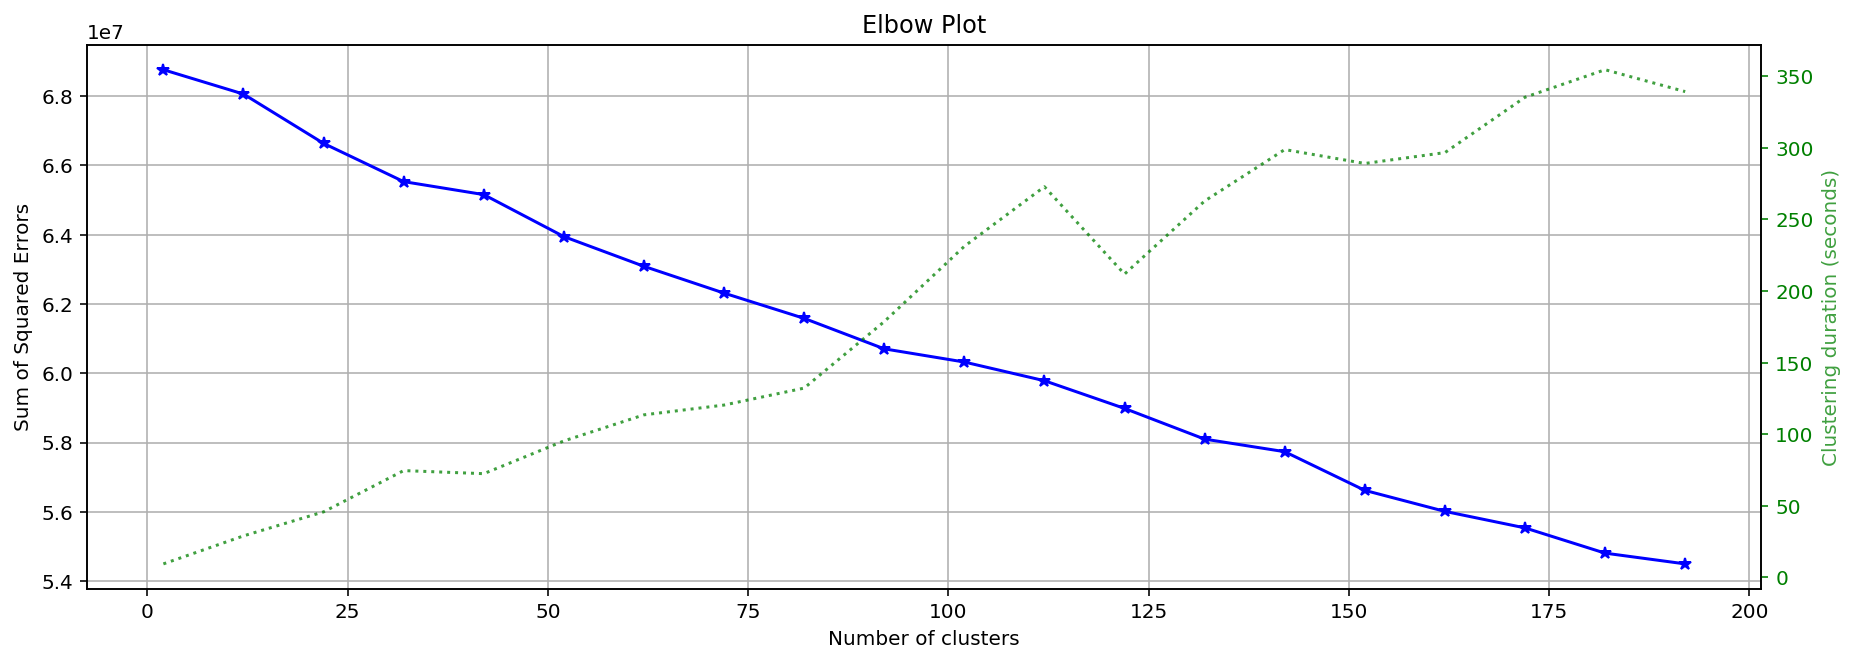

In [87]:
plot_elbow_curve(KMeans(), pca_string, cluster_ranges=range(2, 200,10), figsize = (15,5))

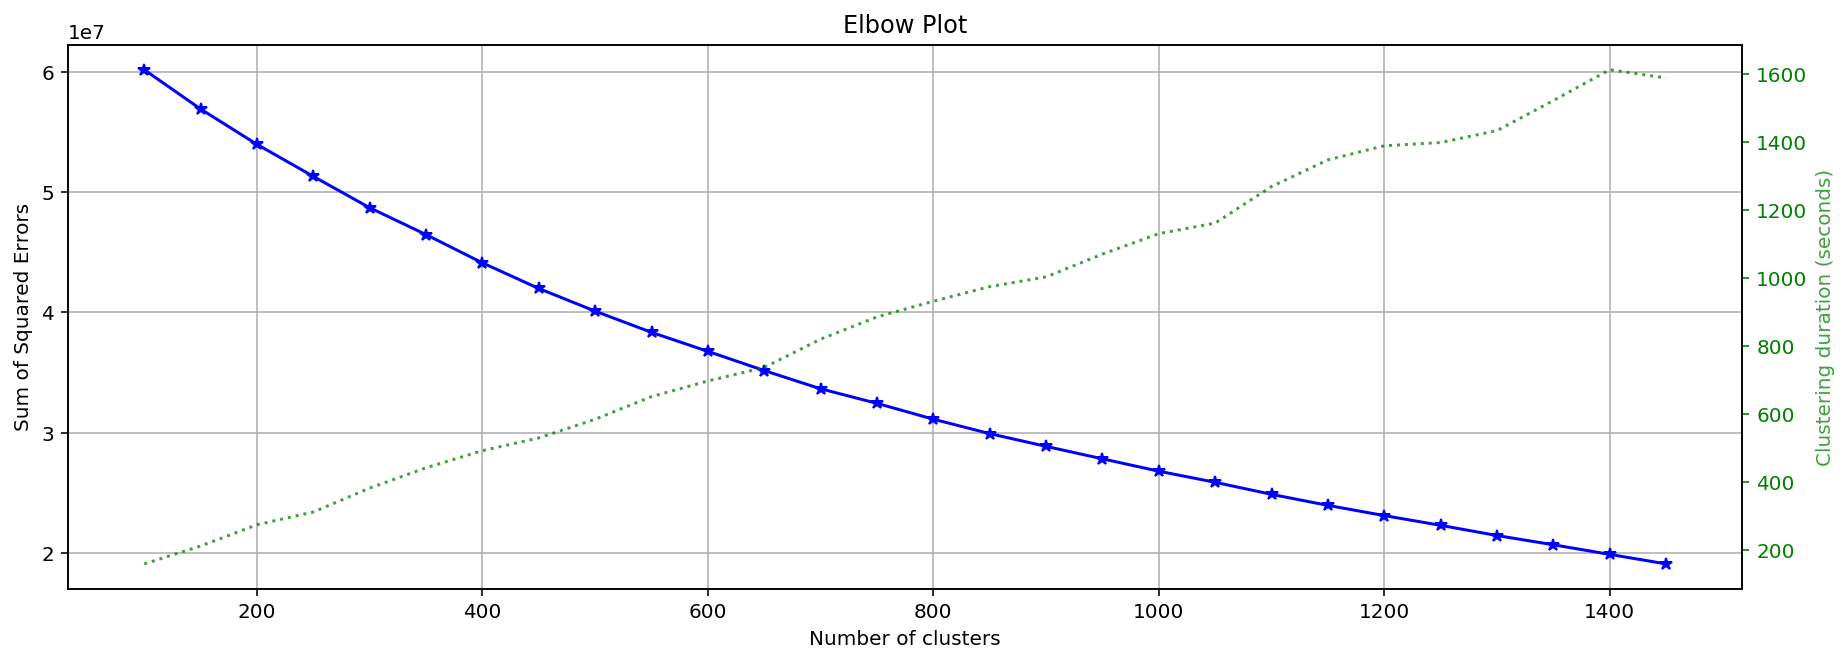

In [20]:
plot_elbow_curve(KMeans(), pca_string, cluster_ranges=range(100, 1500, 50), figsize = (15,5))

From the line plot above the position of the elbow isn't very obvious but the gradient of the curve changes between when k =300 and 600, therefore we will try k = 400 and k = 500:

**k = 500:**

In [71]:
kmean_500 = KMeans(n_clusters=500, random_state=0, n_jobs = -1)
kmean_500.fit(pca_string)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=500, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [220]:
kmeanlabel500 = kmean_500.labels_
medium_cluster['kmean_pca_500'] = kmeanlabel500.tolist()
medium_cluster.kmean_pca_500.value_counts().head(10)

163    6603
363    4182
283    2020
8      1677
36     1526
10     1449
339     945
380     767
18      601
3       457
Name: kmean_pca_500, dtype: int64

In [228]:
medium_cluster.columns

Index(['String', 'dbscan_5', 'dbscan_4', 'dbscan_3', 'dbscan_2', 'dbscan_1',
       'dbscan_2t', 'dbscant_0_5', 'dbscant_1', 'dbscant_0_75', 'dbscant_0_65',
       'dbscant_0_85', 'kmean_pca_500', 'kmean_pca_400', 'db_pca_1',
       'kmodel_400', 'kmodel_500'],
      dtype='object')

In [238]:
medium_cluster[medium_cluster.kmean_pca_500==363].head(3)

,String,kmean_pca_500,kmean_pca_400
27,screenprint in colors with hand-coloring and c...,363,80
59,Lithograph in colors on german copperplate,363,80
121,etching in colors,363,80


In [237]:
medium_cluster[medium_cluster.kmean_pca_500==8].head(3)

,String,kmean_pca_500,kmean_pca_400
32,lithograph in pink,8,29
102,etching in black and blue-black on Arches wove...,8,29
104,lithograph in black and red,8,29


**k = 400:**

In [131]:
kmean_400 = KMeans(n_clusters=400, random_state=0, n_jobs = -1)
kmean_400.fit(pca_string)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=400, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [239]:
kmeanlabel400 = kmean_400.labels_
medium_cluster['kmean_pca_400'] = kmeanlabel400.tolist()
medium_cluster.kmean_pca_400.value_counts().head(10)

29     8246
80     5056
14     2069
205    1703
185     964
184     877
35      870
210     778
253     456
11      374
Name: kmean_pca_400, dtype: int64

In [240]:
medium_cluster[medium_cluster.kmean_pca_400 == 185].head(3)

,String,kmean_pca_500,kmean_pca_400
50,Lithograph on Rives paper,339,185
58,Color lithograph on Rives BFK,339,185
62,Color lithograph on Rives BFK paper,339,185


In [250]:
medium_cluster[medium_cluster.kmean_pca_400 == 14].head(3)

,String,kmean_pca_500,kmean_pca_400
0,"Color offset lithogragh, screen and pochoir wi...",36,14
33,screenprint and offset lithograph with collage...,36,14
46,offset lithograph and screenprint in colors wi...,247,14


**DBscan Clustering Algorithm:**
- As this doesn't require a pre-set number of clusters the main task is to alter the parameters

In [172]:
db_pca_30 = DBSCAN(eps=30, min_samples=1, n_jobs = -1)
db_pca_30.fit(pca_string)
dbpca_label_30 = db_pca_30.labels_
n_clusters_ = len(set(dbpca_label_30) - set([-1]))
print(n_clusters_)

3102


In [183]:
db_pca_150 = DBSCAN(eps=150, min_samples=1, n_jobs = -1)
db_pca_150.fit(pca_string)
dbpca_label_150 = db_pca_150.labels_
n_clusters_ = len(set(dbpca_label_150) - set([-1]))
print(n_clusters_)

354


In [187]:
pd.DataFrame(dbpca_label_150.tolist())[0].value_counts().head()

0      24325
60         4
33         3
318        3
279        3
Name: 0, dtype: int64

In [182]:
db_pca_200 = DBSCAN(eps=200, min_samples=1, n_jobs = -1)
db_pca_200.fit(pca_string)
dbpca_label_200 = db_pca_200.labels_
n_clusters_ = len(set(dbpca_label_200) - set([-1]))
print(n_clusters_)

247


In [186]:
pd.DataFrame(dbpca_label_200.tolist())[0].value_counts().head()

0      24461
147        2
2          2
142        2
165        2
Name: 0, dtype: int64

In [258]:
db_pca_150 = DBSCAN(eps=0.7, min_samples=1,metric = 'cosine', n_jobs = -1)
db_pca_150.fit(pca_string)
dbpca_label_150 = db_pca_150.labels_
n_clusters_ = len(set(dbpca_label_150) - set([-1]))
print(n_clusters_)

722


In [259]:
pd.DataFrame(dbpca_label_150.tolist())[0].value_counts().head()

1      23674
446       13
623       10
84         8
495        7
Name: 0, dtype: int64

In [260]:
db_pca_85 = DBSCAN(eps=0.85, min_samples=1,metric = 'cosine', n_jobs = -1)
db_pca_85.fit(pca_string)
dbpca_label_85 = db_pca_85.labels_
n_clusters_ = len(set(dbpca_label_85) - set([-1]))
print(n_clusters_)

385


In [282]:
pd.DataFrame(dbpca_label_85.tolist())[0].value_counts().head()

0      24195
367        7
265        7
352        6
125        5
Name: 0, dtype: int64

In [262]:
medium_cluster['db_pca_85'] = dbpca_label_85.tolist()

In [275]:
medium_cluster[medium_cluster['db_pca_85'] == 106]

,String,kmean_pca_500,kmean_pca_400,db_pca_85
6866,etchings and engraving on Romani wove paper,363,35,106


In [277]:
medium_cluster[medium_cluster['db_pca_85'] == 169]

,String,kmean_pca_500,kmean_pca_400,db_pca_85
10981,Lithograph and screenprint in colors with hand...,163,11,169


In [278]:
medium_cluster[medium_cluster['db_pca_85'] == 0].head(4)

,String,kmean_pca_500,kmean_pca_400,db_pca_85
0,"Color offset lithogragh, screen and pochoir wi...",36,14,0
1,"Color lithograph, screenprint, pochoir, collag...",163,29,0
2,Lithograph in color,163,29,0
3,offset lithograph,163,29,0


In [279]:
db_pca_95 = DBSCAN(eps=0.95, min_samples=1,metric = 'cosine', n_jobs = -1)
db_pca_95.fit(pca_string)
dbpca_label_95 = db_pca_95.labels_
n_clusters_ = len(set(dbpca_label_95) - set([-1]))
print(n_clusters_)

29


In [281]:
medium_cluster['db_pca_95'] = dbpca_label_95.tolist()
medium_cluster.db_pca_95.value_counts().head()

0     24676
20        3
13        2
17        2
10        2
Name: db_pca_95, dtype: int64

#### Cluster Method selected: Kmean, n_cluster = 400:
- From inspection of cluster groups derived from both Kmean and DBSCAN
- Kmean cluster method is able to cluster the strings better
- DBSCAN is collecting majority into one big cluster with the rest as outliers 


In [284]:
medium_categories = medium_cluster[['String', 'kmean_pca_400']]

In [287]:
medium_categories.rename(columns = {'String':'Art_medium', 'kmean_pca_400':'Medium_Class'}, inplace = True)

In [651]:
subset_c = subset_b.merge(medium_categories, how = 'inner', on = 'Art_medium')

In [652]:
subset_c

,Title,Artist,Year,Venue,Art_medium,Signed,Total_prints,Area_dimension,Realized_Price,Sale_date,Sale_Year,Sale_Month,Sale_Day,Venue_city,Date,Alive,Est_Year,Art_period,Medium_Class
0,HORSEFEATHERS THIRTEEN-XIII,Robert Rauschenberg,1972.0,Doyle New York,"Color offset lithogragh, screen and pochoir wi...",1,78.0,580.500000,1000,2012-10-16,2012,10,16,New York,"[1925, 2008]",0,1950.0,Abstract_Expressionism,14
1,Horsefeathers Thirteen XV,Robert Rauschenberg,1972.0,Swann Auction Galleries,"Color lithograph, screenprint, pochoir, collag...",1,1.0,279.500000,1000,2012-11-15,2012,11,15,New York,"[1925, 2008]",0,1950.0,Abstract_Expressionism,29
2,Gulf,Robert Rauschenberg,1969.0,Gray's Auctioneers,Lithograph in color,1,56.0,1471.343750,1000,2015-07-31,2015,7,31,Cleveland,"[1925, 2008]",0,1950.0,Abstract_Expressionism,29
3,L'Artiste Phenix,Marc Chagall,1972.0,Cheffins,Lithograph in color,1,50.0,588.000000,5000,2018-05-10,2018,5,10,Cambridge,"[1887, 1985]",0,1916.0,CFSCD,29
4,Couple in Ochre (Mourlot 59),Marc Chagall,1952.0,Weschler's,Lithograph in color,1,100.0,543.250000,3600,2014-02-28,2014,2,28,Rockville,"[1887, 1985]",0,1916.0,CFSCD,29
5,L'Artiste Phenix,Marc Chagall,1972.0,A.N. Abell Auction Company,Lithograph in color,1,50.0,588.000000,5000,2018-05-20,2018,5,20,Los Angeles,"[1887, 1985]",0,1916.0,CFSCD,29
6,LA PASSION,Marc Chagall,1975.0,Lyon & Turnbull,Lithograph in color,1,1.0,147.580000,7062,2007-08-29,2007,8,29,Lyon,"[1887, 1985]",0,1916.0,CFSCD,29
7,DAVID SAVED BY MICHAEL,Marc Chagall,1960.0,Lyon & Turnbull,Lithograph in color,1,1.0,143.820000,9080,2007-08-29,2007,8,29,Lyon,"[1887, 1985]",0,1916.0,CFSCD,29
8,May Milton (Adhémar 194),Henri de Toulouse-Lautrec,1895.0,Weschler's,Lithograph in color,1,25.0,744.000000,11000,2016-09-16,2016,9,16,Rockville,"[1864, 1901]",0,1875.0,Impressionism_Realism,29
9,Brush after eating,Jim Dine,1963.0,Christie's Paris,Lithograph in color,0,1.0,1254.750000,2011,2018-10-18,2018,10,18,Paris,[1935],1,1960.0,Pop Art,29


### Historical Pricing by Artist and Year:

---
<a id="previousprice"></a>

- To take into consideration of historical pricing for previous artwork sold by each artist
- I will create a feature based on the previous annual performance for each artist

#### Creating a dictionary for the mean realized price per year, 1998-2019:

In [76]:
subset_c = pd.read_csv('./subset_d.csv')

In [77]:
grouped_by_Sale_year = subset_c.groupby('Sale_Year')
annualsale_dict = dict(zip(grouped_by_Sale_year.Realized_Price.mean().index.tolist(),
                    grouped_by_Sale_year.Realized_Price.mean().values.tolist()))

In [78]:
annualsale_dict

{1998: 14202.484251968504,
 1999: 13852.67365967366,
 2000: 15902.770197486536,
 2001: 12510.842920353982,
 2002: 11203.698985343855,
 2003: 9773.824964805255,
 2004: 12264.81943879626,
 2005: 13719.989735614308,
 2006: 14162.487810884018,
 2007: 19345.892792384406,
 2008: 13406.405201342282,
 2009: 13589.88025477707,
 2010: 17536.97142857143,
 2011: 18341.283965728275,
 2012: 17264.505205905207,
 2013: 18593.673733947177,
 2014: 17831.834703196346,
 2015: 16602.807462861154,
 2016: 15965.018480243161,
 2017: 16476.796939439984,
 2018: 17171.2934234416,
 2019: 19541.969791963522}

#### Grouping by Artist and Sale Year, giving the mean realized price and sale count for each artist per year:

In [79]:
grouped_by_Artist_Sale = subset_c.groupby(['Artist','Sale_Year'])['Realized_Price'].mean()

In [80]:
Artist_Sale_df = pd.DataFrame(grouped_by_Artist_Sale)

In [81]:
Artist_Sale_df.reset_index(inplace = True)

In [82]:
Artist_Sale_df.rename(columns={'Realized_Price':'Mean_artist_price'}, inplace = True)

In [83]:
grouped_by_Sale_count = subset_c.groupby(['Artist','Sale_Year'])['Realized_Price'].count()

In [15]:
len(grouped_by_Sale_count)

5045

In [84]:
Artist_Sale_df['Count'] = grouped_by_Sale_count.tolist()

#### Creating a performance index:
- Each artist is given an annual performance index for every year:
    - This is the( mean artist price for the year)*(Count Factor)/ the mean price of all the art work that year
    - Count factor = the square root of the artist sale count for the year, this is squarerooted to scale it down
- The annual performance is then shifted for every year so for each artist per year it has information on all the previous annual performance 
- The performance index is then calculated by taking mean of the last 3 annual performance index, each multiplied by a decay factor
- I made two different performance indexes, which will be tested and the best will be included:
    - Linear: takes the last 3 annual performance and without taking into account of which year each one is multiplied by a linear decay factor
    - exponential time decay: takes the last 3 annual performance multipled by exp(-t/10) where t is the year difference from the year of calculation. A 10 year decay was chosen.

In [85]:
def annual_perf(row):
    year = row['Sale_Year']
    count_factor = np.sqrt(row['Count'])
    return row['Mean_artist_price']*count_factor/annualsale_dict[year]

In [86]:
Artist_Sale_df['artist_annual_performance'] = Artist_Sale_df.apply(annual_perf,axis=1)

In [87]:
yearlist = pd.DataFrame(subset_c.Sale_Year.unique().tolist())

In [88]:
yearlist.sort_values(by=0, inplace = True)

In [89]:
yearlist.rename(columns={0:'Sale_Year'},inplace = True)

In [90]:
def sum_shifts_exp(row):
    count = 0
    sumshift = []
    for i in range(0,21):
        if pd.notnull(row['shift_{}'.format(i)]) and count<3:
                sumshift.append(row['shift_{}'.format(i)])
                count +=1
        else:
            pass
    length = len(sumshift)
    if length < 3:
        return np.nan
    else:
        return np.mean(sumshift)

In [91]:
artist_index_list = []
for i in Artist_Sale_df.Artist.unique().tolist():
    a = Artist_Sale_df[Artist_Sale_df.Artist == i].merge(yearlist, how = 'outer', on = 'Sale_Year').sort_values(by='Sale_Year').reset_index(drop = True)
    values = {'Artist':i, 'Mean_artist_price':0,'Count':0}
    a.fillna(value = values, inplace = True)
    a.drop(columns = ['Mean_artist_price','Count'],inplace = True)
    for j in range(0,21):
        a['shift_{}'.format(j)] = a.artist_annual_performance.shift(j+1)
        a['shift_{}'.format(j)] = a['shift_{}'.format(j)]*np.exp(-j/10)
    a['performance_index'] = a.apply(sum_shifts_exp, axis =1)
    a = a[['Artist','Sale_Year','performance_index']]
    artist_index_list.append(a)

In [92]:
artist_performance = pd.concat(artist_index_list)

In [94]:
artist_performance.columns

Index(['Artist', 'Sale_Year', 'artist_annual_performance', 'shift_0',
       'shift_1', 'shift_2', 'shift_3', 'shift_4', 'shift_5', 'shift_6',
       'shift_7', 'shift_8', 'shift_9', 'shift_10', 'shift_11', 'shift_12',
       'shift_13', 'shift_14', 'shift_15', 'shift_16', 'shift_17', 'shift_18',
       'shift_19', 'shift_20', 'performance_index'],
      dtype='object')

In [25]:
def sum_shifts_linear(row):
    count = 0
    sumshift = []
    linlist = [1, 0.667, 0.333]
    for i in range(0,21):
        if pd.notnull(row['shift_{}'.format(i)]) and count<3:
                sumshift.append(row['shift_{}'.format(i)])
                count +=1
        else:
            pass
    length = len(sumshift)
    if length < 3:
        return np.nan
    else:
        sumshifts = [j*k for j,k in zip(sumshift,linlist)]
        return np.mean(sumshifts)

In [26]:
artist_linear_list = []
for i in Artist_Sale_df.Artist.unique().tolist():
    a = Artist_Sale_df[Artist_Sale_df.Artist == i].merge(yearlist, how = 'outer', on = 'Sale_Year').sort_values(by='Sale_Year').reset_index(drop = True)
    values = {'Artist':i, 'Mean_artist_price':0,'Count':0}
    a.fillna(value = values, inplace = True)
    a.drop(columns = ['Mean_artist_price','Count'],inplace = True)
    for j in range(0,21):
        a['shift_{}'.format(j)] = a.artist_annual_performance.shift(j+1)
        
    a['linear_perf_index'] = a.apply(sum_shifts_linear, axis =1)
    a = a[['Artist','Sale_Year','linear_perf_index']]
    artist_linear_list.append(a)
    

In [27]:
artist_linear_list[0][5:10]

,Artist,Sale_Year,linear_perf_index
5,Adolph Gottlieb,2003,NaN
6,Adolph Gottlieb,2004,NaN
7,Adolph Gottlieb,2005,NaN
8,Adolph Gottlieb,2006,0.275838
9,Adolph Gottlieb,2007,0.256702


In [28]:
artist_performance[7:10]

,Artist,Sale_Year,performance_index
7,Adolph Gottlieb,2005,NaN
8,Adolph Gottlieb,2006,0.360107
9,Adolph Gottlieb,2007,0.331148


In [29]:
lin_artist_performance = pd.concat(artist_linear_list)

In [30]:
artist_performance['linear_perf_index'] = lin_artist_performance.linear_perf_index

In [31]:
Artist_Sale_df = Artist_Sale_df.merge(artist_performance, how ='inner', on=['Artist','Sale_Year'])

In [653]:
subset_d = subset_c.merge(artist_performance, how ='inner', on=['Artist','Sale_Year'])

In [655]:
subset_d.to_csv('subset_d.csv')

### Classifaction Category:
---

- Cleaning a preparing a data set for an alternative classification model to predict whether a art piece by a specific artist will do better than the previous year's mean sale price. 

In [3]:
subset_d = pd.read_csv('subset_d.csv')

In [4]:
subset_d.drop(columns = 'Unnamed: 0', inplace = True)

In [ ]:
Artist_Sale_df = pd.read_csv('subset_d.csv')

In [32]:
Artist_Sale_df.head()

,Artist,Sale_Year,Mean_artist_price,Count,artist_annual_performance,performance_index,linear_perf_index
0,Adolph Gottlieb,2003,2425.333333,3,0.429801,NaN,NaN
1,Adolph Gottlieb,2004,2271.000000,1,0.185164,NaN,NaN
2,Adolph Gottlieb,2005,2908.571429,7,0.560886,NaN,NaN
3,Adolph Gottlieb,2006,2367.500000,4,0.334334,0.360107,0.275838
4,Adolph Gottlieb,2007,2956.600000,5,0.341734,0.331148,0.256702


In [45]:
mean_price_shift = []
for i in Artist_Sale_df.Artist.unique().tolist():
    a = Artist_Sale_df[Artist_Sale_df.Artist == i].merge(yearlist, how = 'outer', on = 'Sale_Year').sort_values(by='Sale_Year').reset_index(drop = True)
    values = {'Artist':i}
    a.fillna(value = values, inplace = True)
    a.drop(columns = ['Count','artist_annual_performance'],inplace = True)
    for j in range(0,21):
        a['shift_{}'.format(j)] = a.Mean_artist_price.shift(j+1)
        a['shift_{}'.format(j)] = a['shift_{}'.format(j)]*np.exp(-j/10)

    mean_price_shift.append(a)

In [98]:
meanshift_df = pd.concat(mean_price_shift)
meanshift_df.head(2)

,Artist,Sale_Year,Mean_artist_price,performance_index,linear_perf_index,shift_0,shift_1,shift_2,shift_3,shift_4,...,shift_11,shift_12,shift_13,shift_14,shift_15,shift_16,shift_17,shift_18,shift_19,shift_20
0,Adolph Gottlieb,1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Adolph Gottlieb,1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
def last_shifts(row):
    count = 0
    sumshift = []

    for i in range(0,21):
        if pd.notnull(row['shift_{}'.format(i)]) and count<3:
                sumshift.append(row['shift_{}'.format(i)])
                count +=1
        else:
            pass
    
    try:
        return sumshift[2]
    except:
        return np.nan

In [52]:
meanshift_df['hist_3'] = meanshift_df.apply(last_shifts, axis =1)

In [53]:
meanshift_df = meanshift_df[['Artist','Sale_Year','hist_1','hist_2','hist_3']]

In [54]:
meanshift_df.shape

(6556, 5)

In [55]:
subset_clas = subset_d.merge(meanshift_df, how ='inner', on=['Artist','Sale_Year'])

In [56]:
subset_clas.dropna(subset = ['hist_1'], inplace = True)

In [57]:
subset_clas.head()

,Title,Artist,Year,Venue,Art_medium,Signed,Total_prints,Area_dimension,Realized_Price,Sale_date,...,Date,Alive,Est_Year,Art_period,Medium_Class,performance_index,linear_perf_index,hist_1,hist_2,hist_3
0,HORSEFEATHERS THIRTEEN-XIII,Robert Rauschenberg,1972.0,Doyle New York,"Color offset lithogragh, screen and pochoir wi...",1,78.0,580.50,1000,2012-10-16,...,"[1925, 2008]",0,1950.0,Abstract_Expressionism,14,5.494042,3.878156,14341.735294,7661.801321,14124.664978
1,Horsefeathers Thirteen XV,Robert Rauschenberg,1972.0,Swann Auction Galleries,"Color lithograph, screenprint, pochoir, collag...",1,1.0,279.50,1000,2012-11-15,...,"[1925, 2008]",0,1950.0,Abstract_Expressionism,29,5.494042,3.878156,14341.735294,7661.801321,14124.664978
2,Breakthrough II (Foster 27; Sparks 23),Robert Rauschenberg,1965.0,Christie's New York,lithograph in colors on wove paper,1,34.0,1644.75,122500,2012-10-30,...,"[1925, 2008]",0,1950.0,Abstract_Expressionism,29,5.494042,3.878156,14341.735294,7661.801321,14124.664978
3,Untitled (Harp),Robert Rauschenberg,1989.0,Christie's New York,lithograph in colors,1,1.0,1221.00,2500,2012-06-19,...,"[1925, 2008]",0,1950.0,Abstract_Expressionism,29,5.494042,3.878156,14341.735294,7661.801321,14124.664978
4,Collage,Robert Rauschenberg,1984.0,Cowan's Cincinnati,Lithograph,1,1.0,88.00,15275,2012-02-25,...,"[1925, 2008]",0,1950.0,Abstract_Expressionism,29,5.494042,3.878156,14341.735294,7661.801321,14124.664978


#### Creating 4 categories: Strong Sell, Sell, Buy and Strong Buy
- Strong sell is when the sale price of the art piece is beyond the 3rd quartile
- Sell is above or equivalent to average
- Buy is below average
- Strong Buy is below 1st quartile

In [58]:
def buy_sell_target(row):
    if row['Realized_Price']> row['hist_1']*2:
        return 'Strong_Sell'
    elif row['Realized_Price']> row['hist_1']:
        return 'Sell'
    elif row['Realized_Price'] == row['hist_1']:
        return 'Sell'
    elif row['Realized_Price'] < row['hist_1']*0.6:
        return 'Strong_Buy'
    else:
        return 'Buy'

In [59]:
subset_clas['Target'] = subset_clas.apply(buy_sell_target, axis = 1)

In [60]:
classifier_subset = subset_clas[['Artist','Art_period','Medium_Class',
       'Signed', 'Total_prints', 'Area_dimension', 'Sale_Year', 'Sale_Month', 'Sale_Day', 'Venue_city','Alive','performance_index',
                                 'hist_1','hist_2','hist_3', 'Target']]



In [61]:
classifier_subset['diff_1'] = classifier_subset.apply(lambda x: x[12]/x[13], axis = 1)

In [62]:
classifier_subset['diff_2'] = classifier_subset.apply(lambda x: x[13]/x[14], axis = 1)

In [63]:
classifier_subset.drop(columns = ['hist_2','hist_3'], inplace = True)

In [64]:
classifier_subset.to_csv('categorical_data.csv')

In [124]:
classifier_subset.columns

Index(['Artist', 'Art_period', 'Medium_Class', 'Signed', 'Total_prints',
       'Area_dimension', 'Sale_Year', 'Sale_Month', 'Sale_Day', 'Venue_city',
       'Alive', 'performance_index', 'hist_1', 'Target', 'diff_1', 'diff_2'],
      dtype='object')

In [65]:
classifier_subset.Target.value_counts()

Strong_Buy     46806
Buy            22821
Sell           19431
Strong_Sell    12175
Name: Target, dtype: int64

### Final clean dataset:

---
<a id="dataset"></a>

In [658]:
subset_d.columns

Index(['Title', 'Artist', 'Year', 'Venue', 'Art_medium', 'Signed',
       'Total_prints', 'Area_dimension', 'Realized_Price', 'Sale_date',
       'Sale_Year', 'Sale_Month', 'Sale_Day', 'Venue_city', 'Date', 'Alive',
       'Est_Year', 'Art_period', 'Medium_Class', 'performance_index',
       'linear_perf_index'],
      dtype='object')

In [675]:
subset_e = subset_d[['Artist','Art_period','Medium_Class',
       'Signed', 'Total_prints', 'Area_dimension', 'Sale_Year', 'Sale_Month', 'Sale_Day', 'Venue_city','Alive','performance_index',
       'linear_perf_index','Realized_Price']]

In [676]:
subset_e.to_csv('art_data.csv')

In [671]:
subset_e.head()

,Artist,Art_period,Medium_Class,Signed,Total_prints,Area_dimension,Sale_date,Sale_Year,Sale_Month,Sale_Day,Venue_city,Alive,performance_index,linear_perf_index,Realized_Price
0,Robert Rauschenberg,Abstract_Expressionism,14,1,78.0,580.50,2012-10-16,2012,10,16,New York,0,5.494042,3.878156,1000
1,Robert Rauschenberg,Abstract_Expressionism,29,1,1.0,279.50,2012-11-15,2012,11,15,New York,0,5.494042,3.878156,1000
2,Robert Rauschenberg,Abstract_Expressionism,29,1,34.0,1644.75,2012-10-30,2012,10,30,New York,0,5.494042,3.878156,122500
3,Robert Rauschenberg,Abstract_Expressionism,29,1,1.0,1221.00,2012-06-19,2012,6,19,New York,0,5.494042,3.878156,2500
4,Robert Rauschenberg,Abstract_Expressionism,29,1,1.0,88.00,2012-02-25,2012,2,25,Cincinnati,0,5.494042,3.878156,15275


In [673]:
subset_e.shape

(102013, 15)

In [668]:
for i in subset_e.columns:
    print(i,': ', len(subset_d[i].value_counts()))

Artist :  298
Art_period :  9
Medium_Class :  362
Signed :  2
Total_prints :  476
Area_dimension :  32694
Sale_date :  3027
Sale_Year :  22
Sale_Month :  12
Sale_Day :  31
Venue_city :  252
Alive :  2
performance_index :  4170
linear_perf_index :  4170
Realized_Price :  15804
